In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Uncomment in case packages are not installed
#!pip install timm
#!pip install transformers
#!pip install pyspellchecker

In [ ]:
import torch
#import clip
import argparse
import numpy as np

import torch
torch.cuda.empty_cache()
import pandas as pd
import re

import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

#NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# Lemmatizer helps to reduce words to the base form
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('words')
# Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams
nltk.download('names')
from nltk.corpus import names 
# We can use counter to count the objects
from collections import Counter

from spellchecker import SpellChecker

import spacy

import operator

# This is our visual library
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import math
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Pre-processing

Preprocessing based on regular expressions. It eliminates web pages (.com), social media users with @, emails, hours and dates (accounting for screenshots with hours and dates) (what about others like comments, likes, shares). It also expands contractions. Lastly, it substracts special characters but periods, replace multiple spaces and periods by one space/period and delete spaces at the end or beggining of transcript.

In [10]:
def preprocess_regex(text):

  #text = str.lower(text)
  text = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.(?!(zip))([a-zA-Z()]{1,6})', '', text)# web pages except .zip
  text = re.sub(r'@[a-zA-Z0-9.-]+', '', text)# Matches social media users
  text = re.sub(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,4}\b', '', text)# Matches emails
  text = re.sub(r'([0-1]?[0-9]|2[0-3]):[0-5][0-9](\s+\b(am|pm)\b)?\s+', '', text)# Find time HH:MM
  text = re.sub(r'(jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+([0-2][0-9]|3[0-1]),?\s+(\d{4})', '', text)

    # general
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)
  
  #text = re.sub('[^a-zA-Z.\d\s]', '', text)# Delete special characters
  text = re.sub('\.{2,}', '.', text) # Replace multiple dots by one dot
  text = re.sub('\s{2,}', ' ', text) # replace multiple spaces by one space
  text = re.sub('^\s+|\s+$', '', text) # Delete spaces at the beggining or end of text

  return text

Pre process text to use POS tagging afterwards. This function is to be called by each transcript (each row). It receives the text to pre-process; an spacy (nlp) object to tokenize the text, get the POS taggs and lemmatize the tokens; words that contain words in the english dictionary; a list of names for males and females; a list of profanity words; and a spell checker object. This helps to filter the final tokens. After ruling out the tokens tagged as other (X) or proper nouns (PROPN), it checks if the lemmatized form is a pronoun. If it is, it adds the complete word, if it's not it adds the lemmatized form. Also, if the tokens belogn to any of the provided lists, it is kept. Then, the lemmatized tokens are evaluated to take out the stopwords and keep  only alphabetic characters (letters). Finally, the tokens are joined into a string to return.

In [11]:
def pre_process_POS(text, nlp, words, namelist, profanity_words, spell):

  #Creating doc object
  doc = nlp(text)
  #Extracting POS
  lemma_tokens = []
  #discarded = []
  for token in doc:
    if token.pos_ != 'X' and token.pos_ != 'PROPN':
      if token.lemma_ == '-PRON-':
        lemma_tokens.append(token.text)
      else:
          lemma_tokens.append(token.lemma_)
    elif (token.text in words) or (token.text in namelist) or (len(spell.unknown([token.text]))==0) or (token.text in profanity_words):
      if token.lemma_ == '-PRON-':
        lemma_tokens.append(token.text)
      else:
        lemma_tokens.append(token.lemma_)

      #print(token.text)
    #else:
     # discarded.append([token.text, token.pos_])
  #print('lemma: ', lemma_tokens)
  #print(discarded)

  # Take out the stopwords
  text_tokens =[t for t in lemma_tokens if t not in stopwords.words('english')]
  #print('stopwords: ',text_tokens)

  # Extract only the alphabetic characters (deletes numbers too)
  non_text_tokens = [t for t in text_tokens if t.isalpha() == False]
  #print(non_text_tokens)
  text_tokens = [t for t in text_tokens if t.isalpha()]

  return ' '.join(text_tokens) # Returns a tokens as string

process_data reads the CSV file and process it to get clean texts (transcripts). It saves a cleaned text and a processed text (string of tokens). It returns a processed dataframe

In [12]:
def process_data(dir_path, clean_data_file=1):

  if clean_data_file==1:
    df_clean = pd.read_csv(dir_path+'cleaned_texts.csv', header='infer')
  else:
    # Read data from original csv file and lower case the texts
    data_info = pd.read_csv('/MAMI/data/training.csv', sep='\t', header='infer')
    #data_info = pd.read_csv('MAMI/data/Test.csv', sep='\t', header='infer')
    data_info = data_info.rename({'Text Transcription': 'transcripts'}, axis=1)
    data_info['transcripts'] = data_info['transcripts'].str.lower()

    #Clean the texts bby applying the preprocess_regex. Save the dataframe into 'cleaned_texts.csv'
    df_clean = data_info.copy()
    df_clean['transcripts'] = df_clean.apply(lambda row : preprocess_regex(row[6]), axis = 1) #Apply preprocess_regex to row 6 ('transcripts')
    df_clean.to_csv('cleaned_texts.csv', index=False)
    %cp -av cleaned_texts.csv $dir_path # Save data with cleaned texts from regex

  ##### Apply pre_process_POS to pre-process the texts (applying POS tagging). Save the new dataframe as 'processed_texts.csv' #####

  # Construct a list of classified names, using the names corpus.
  namelist = ([name.lower() for name in names.words('male.txt')] + [name.lower() for name in names.words('female.txt')])
  #Swear words from google_profanity_words.txt
  profanity_words = {'chink', 'b00bs', 'donkeyribber', 'kunilingus', 'mutherfucker', 'fudge packer', 'semen', 'motherfuckings', 'jiz', 'pussies', 'fux', 'cipa', 'boner', 'jerk-off', 'jackoff', 'nobjokey', 'beastiality', 'poop', '5hit', 'shited', 'fukkin', 'fistfuck', 'lusting', 's hit', 'jap', 'cumming', 'fingerfucking', 'pissing', 'gangbang', 'boooobs', 'whore', 'fukwhit', 'kum', 'masterb8', 'dick', 'muff', 'fagging', 'nigger', 'v1gra', 'twunter', 'pecker', 'l3i+ch', 'fuckings', 'duche', 'breasts', 'pimpis', 'kums', 'cuntlick', 'tittie5', 'fingerfucked', 'rimjaw', 'fuckwit', 'tittywank', 'fucked', 'beastial', 'ma5terbate', 'dogging', 'l3itch', 'mothafuck', 'feck', 'm0f0', 'cok', 'w00se', 'm0fo', 'shittings', 'horniest', 'phuked', 'penis', 'boobs', 'masterbation', 'cunnilingus', 'a_s_s', 'assfukka', 'cockmuncher', 'orgasm', 'muthafuckker', 'cuntlicking', 'knobead', 'mothafuckaz', 'pissin', 'clit', 'shemale', 'nazi', 'damn', 'goddamn', 'cunilingus', 'b!tch', 'mutha', 'fuks', 'ejaculation', 'bastard', 'gaylord', 'phuking', 'xxx', 'fags', 'faggot', 'nob', 'faggitt', 'god-dam', 'buttplug', 'mothafucka', 'muther', 'p0rn', 'cocksukka', 'cl1t', 'shitey', 'tw4t', 'ejaculate', 'teets', 'tittyfuck', 'f u c k e r', 'pussy', 'dirsa', 'ejakulate', 'shitted', 'willies', 'fellate', 'cums', 'fuckwhit', 'ma5terb8', 'mof0', 'bloody', 'asswhole', 't1tt1e5', 'masochist', 'motherfuckin', 'hardcoresex', 'heshe', 'mothafucks', 'asses', 'goddamned', 'phuks', 'homo', 'horny', 'balls', 'hotsex', 'kumming', 'mothafuckin', 'bi+ch', 'ass-fucker', 'fooker', 'numbnuts', 'cyberfuckers', 'fuckme', 'fannyflaps', 'coon', 'jizz', 'booooooobs', 'pissoff', 'wang', 'prick', 'fingerfuckers', 'f u c k', 'bitcher', 'smegma', 'testical', 'skank', 'twat', 'nobhead', 'fistfuckers', 'boiolas', 'pusse', 'fellatio', 'cumshot', 'fcuk', 'anal', 'motherfuckers', 'knobhead', 'porn', 'tits', 'motherfucks', 'knobjokey', 'kock', 'ejaculating', 'kummer', 'anus', 'labia', 'fudgepacker', 'flange', 'hore', 'assfucker', 'kondum', 'clitoris', 'fistfuckings', 'titwank', 'nigga', 'fuk', 'fuckers', 'mothafuckas', 'tittiefucker', 'pisses', 'shitting', 'fistfucking', 'n1gger', 'motherfuckka', 'God', 'ass', 'cokmuncher', 'cunillingus', 'shag', 'a55', 'bitchin', 'schlong', 'wanky', 'cockhead', 'dildos', 'felching', 'f4nny', 'biatch', 'sluts', 'cum', 'mo-fo', 'orgasms', 'cyberfucking', 'fuck', 'testicle', 'vagina', 'cyalis', 'kawk', 'bitches', 'scrotum', 'fukwit', 'cunts', 'pisser', 'willy', 'bugger', 'v14gra', 'shitings', 'fucking', 'booooobs', 'nigg4h', 'titfuck', 'rectum', 'ar5e', 'fux0r', 'masturbate', 'fucks', '5h1t', 'masterbat3', 'pawn', 'c0cksucker', 'viagra', 'gangbanged', 'ejaculated', 'motherfucker', 'muthafecker', 'hoer', 'fcuker', 'motherfuck', 'clits', 'snatch', 'motherfucking', 'fucka', 'mofo', 'penisfucker', 'turd', 'smut', 'cockmunch', 'b1tch', 'pornos', 'shagging', 'fingerfucks', 'god-damned', 'mothafucking', 'shitfull', 'dickhead', 'pissed', 'pussys', 'shi+', 'phonesex', 'niggaz', 'cocksuka', 'blow job', 'piss', 'arse', 'scrote', 'mother fucker', 'fanyy', 'fatass', 'niggers', 'porno', 'm45terbate', 'shit', 'nutsack', 'knobend', 'dlck', 'shitfuck', 'cock-sucker', 'knobjocky', 'shithead', 'mothafucked', 'cocksucking', 'fcuking', 'mothafucker', 'faggs', 'screwing', 'fuker', 'cockface', 'bum', 'master-bate', 'masterbations', 'blowjobs', 'ballbag', 'tosser', 'cyberfuck', 'cyberfucked', 'vulva', 'nobjocky', 'scroat', 'bestiality', 'ejaculatings', 'phukked', 'cocks', 'fingerfucker', 'hoar', 'fistfucker', 'gaysex', 'd1ck', 'cnut', 'pron', 'shite', 'titties', 'xrated', 'cuntlicker', 'butt', 'orgasims', 'fecker', 'b17ch', 'cyberfucker', 'niggas', 'cocksucks', 'fag', 'phukking', 'pube', 'pussi', 'fuckingshitmotherfucker', 'sh!+', 'rimming', 'shiting', 'jizm', 'coksucka', 'sex', 'motherfucked', 's_h_i_t', 'goatse', 'sh!t', 's.o.b.', 'c0ck', 'butthole', 't1tties', 'lust', 'fanny', 'fucker', 'pigfucker', 'dink', 'twunt', 'mothafuckings', 'shits', 'slut', 'dyke', 'spac', 'fook', 'cock', 'bunny fucker', 'sh1t', 'dildo', 'fukker', 'jack-off', '4r5e', 'dinks', 'wanker', 'son-of-a-bitch', 'pissers', 'fistfucked', 'bellend', 'booobs', 'fuckin', 'wank', 'asshole', 'buttmunch', 'cyberfuc', 'teez', 'bollock', 'n1gga', 'dog-fucker', 'nob jokey', 'cocksucked', 'bitching', 'nigg3r', 'hell', 'sadist', 'shitdick', 'shaggin', 'masterbat*', 'bitch', 'doggin', 'fannyfucker', 'boob', 'masterbate', 'shagger', 'knobed', 'shitters', 'crap', 'fagots', 'blowjob', 'arrse', 'spunk', 'lmfao', 'pissflaps', 'niggah', 'whoar', 'f_u_c_k', 'mothafuckers', 'buceta', 'phuck', 'fuckheads', 'pornography', 'fistfucks', 'carpet muncher', 'bestial', 'shitty', 'kondums', 'jism', 'shitter', 'titt', 'cawk', 'phuq', 'tit', 'bitchers', 'ballsack', 'phuk', 'cox', 'twathead', 'twatty', 'assholes', 'doosh', 'cocksucker', 'bollok', 'fingerfuck', 'knob', 'cocksuck', 'orgasim', 'hoare', 'fagot', 'ejaculates', 'cummer', 'gangbangs', 'pricks', 'fuckhead', 'cunt', 'retard'}
  nlp = spacy.load('en_core_web_sm')
  english_words = set(nltk.corpus.words.words())
  spell = SpellChecker() # It does not discard Twitter, Verizon, iphone...

  df_clean['transcripts'] = df_clean.apply(lambda row : pre_process_POS(row[6], nlp, english_words, namelist, profanity_words, spell), axis = 1)
  df_clean.transcripts = df_clean.transcripts.fillna('') # replace na's with empty strings
  print(len(df_clean[df_clean['transcripts'] == '']), 'rows have empty srtings')

  df_clean.to_csv('processed_texts.csv', index=False, na_rep='')
  %cp -av processed_texts.csv $dir_path
  #df_processed = pd.read_csv('/content/gdrive/MyDrive/Fourth semester/MS_project/MAMI/data/processed_texts.csv', header='infer', keep_default_na=False)

  return df_clean


# **Statistics**

Get statistics from the entire corpus. It joints all transcripts, tokenize the text and count words. It returns a dataframe with the frequencies for each token. plot_word_freq plots a bar plot with word frequencies, it gets the data (as a dataframe) and the number of rows to display 

In [13]:
def get_statistics(dataframe):

  text = ' '.join(dataframe.transcripts)
  # creates tokens
  text_tokens = word_tokenize(text)
  #counts the words, pairs and trigrams
  counted = Counter(text_tokens)
  #counted_2= Counter(ngrams(new_tokens,2))
  #creates data frame
  word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
  #word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
  return word_freq#,word_pairs,trigrams

def plot_word_freq(dataframe, number_words):

  # create subplot of the different data frames
  sns.set(rc={'figure.figsize':(18,18)}, font_scale = 2)
  sns.barplot(x='frequency',y='word',data=dataframe.head(number_words))

Create_table recieves a dataframe with frequencies and the original dataframe. It shows a table with a summary of descriptive statistics. 

In [14]:
def tokens_per_transcript(text):
  return len(text.split(' '))

def create_table(freq_dataframe, df):

  vocabulary = len(freq_dataframe.index)
  number_tokens = freq_dataframe.frequency.sum()
  a = freq_dataframe.describe().loc[['mean', 'min', 'max']]
  average_words = a.loc['mean'][0]
  min = a.loc['min'][0]
  max = a.loc['max'][0]
  profanity_words = {'chink', 'b00bs', 'donkeyribber', 'kunilingus', 'mutherfucker', 'fudge packer', 'semen', 'motherfuckings', 'jiz', 'pussies', 'fux', 'cipa', 'boner', 'jerk-off', 'jackoff', 'nobjokey', 'beastiality', 'poop', '5hit', 'shited', 'fukkin', 'fistfuck', 'lusting', 's hit', 'jap', 'cumming', 'fingerfucking', 'pissing', 'gangbang', 'boooobs', 'whore', 'fukwhit', 'kum', 'masterb8', 'dick', 'muff', 'fagging', 'nigger', 'v1gra', 'twunter', 'pecker', 'l3i+ch', 'fuckings', 'duche', 'breasts', 'pimpis', 'kums', 'cuntlick', 'tittie5', 'fingerfucked', 'rimjaw', 'fuckwit', 'tittywank', 'fucked', 'beastial', 'ma5terbate', 'dogging', 'l3itch', 'mothafuck', 'feck', 'm0f0', 'cok', 'w00se', 'm0fo', 'shittings', 'horniest', 'phuked', 'penis', 'boobs', 'masterbation', 'cunnilingus', 'a_s_s', 'assfukka', 'cockmuncher', 'orgasm', 'muthafuckker', 'cuntlicking', 'knobead', 'mothafuckaz', 'pissin', 'clit', 'shemale', 'nazi', 'damn', 'goddamn', 'cunilingus', 'b!tch', 'mutha', 'fuks', 'ejaculation', 'bastard', 'gaylord', 'phuking', 'xxx', 'fags', 'faggot', 'nob', 'faggitt', 'god-dam', 'buttplug', 'mothafucka', 'muther', 'p0rn', 'cocksukka', 'cl1t', 'shitey', 'tw4t', 'ejaculate', 'teets', 'tittyfuck', 'f u c k e r', 'pussy', 'dirsa', 'ejakulate', 'shitted', 'willies', 'fellate', 'cums', 'fuckwhit', 'ma5terb8', 'mof0', 'bloody', 'asswhole', 't1tt1e5', 'masochist', 'motherfuckin', 'hardcoresex', 'heshe', 'mothafucks', 'asses', 'goddamned', 'phuks', 'homo', 'horny', 'balls', 'hotsex', 'kumming', 'mothafuckin', 'bi+ch', 'ass-fucker', 'fooker', 'numbnuts', 'cyberfuckers', 'fuckme', 'fannyflaps', 'coon', 'jizz', 'booooooobs', 'pissoff', 'wang', 'prick', 'fingerfuckers', 'f u c k', 'bitcher', 'smegma', 'testical', 'skank', 'twat', 'nobhead', 'fistfuckers', 'boiolas', 'pusse', 'fellatio', 'cumshot', 'fcuk', 'anal', 'motherfuckers', 'knobhead', 'porn', 'tits', 'motherfucks', 'knobjokey', 'kock', 'ejaculating', 'kummer', 'anus', 'labia', 'fudgepacker', 'flange', 'hore', 'assfucker', 'kondum', 'clitoris', 'fistfuckings', 'titwank', 'nigga', 'fuk', 'fuckers', 'mothafuckas', 'tittiefucker', 'pisses', 'shitting', 'fistfucking', 'n1gger', 'motherfuckka', 'God', 'ass', 'cokmuncher', 'cunillingus', 'shag', 'a55', 'bitchin', 'schlong', 'wanky', 'cockhead', 'dildos', 'felching', 'f4nny', 'biatch', 'sluts', 'cum', 'mo-fo', 'orgasms', 'cyberfucking', 'fuck', 'testicle', 'vagina', 'cyalis', 'kawk', 'bitches', 'scrotum', 'fukwit', 'cunts', 'pisser', 'willy', 'bugger', 'v14gra', 'shitings', 'fucking', 'booooobs', 'nigg4h', 'titfuck', 'rectum', 'ar5e', 'fux0r', 'masturbate', 'fucks', '5h1t', 'masterbat3', 'pawn', 'c0cksucker', 'viagra', 'gangbanged', 'ejaculated', 'motherfucker', 'muthafecker', 'hoer', 'fcuker', 'motherfuck', 'clits', 'snatch', 'motherfucking', 'fucka', 'mofo', 'penisfucker', 'turd', 'smut', 'cockmunch', 'b1tch', 'pornos', 'shagging', 'fingerfucks', 'god-damned', 'mothafucking', 'shitfull', 'dickhead', 'pissed', 'pussys', 'shi+', 'phonesex', 'niggaz', 'cocksuka', 'blow job', 'piss', 'arse', 'scrote', 'mother fucker', 'fanyy', 'fatass', 'niggers', 'porno', 'm45terbate', 'shit', 'nutsack', 'knobend', 'dlck', 'shitfuck', 'cock-sucker', 'knobjocky', 'shithead', 'mothafucked', 'cocksucking', 'fcuking', 'mothafucker', 'faggs', 'screwing', 'fuker', 'cockface', 'bum', 'master-bate', 'masterbations', 'blowjobs', 'ballbag', 'tosser', 'cyberfuck', 'cyberfucked', 'vulva', 'nobjocky', 'scroat', 'bestiality', 'ejaculatings', 'phukked', 'cocks', 'fingerfucker', 'hoar', 'fistfucker', 'gaysex', 'd1ck', 'cnut', 'pron', 'shite', 'titties', 'xrated', 'cuntlicker', 'butt', 'orgasims', 'fecker', 'b17ch', 'cyberfucker', 'niggas', 'cocksucks', 'fag', 'phukking', 'pube', 'pussi', 'fuckingshitmotherfucker', 'sh!+', 'rimming', 'shiting', 'jizm', 'coksucka', 'sex', 'motherfucked', 's_h_i_t', 'goatse', 'sh!t', 's.o.b.', 'c0ck', 'butthole', 't1tties', 'lust', 'fanny', 'fucker', 'pigfucker', 'dink', 'twunt', 'mothafuckings', 'shits', 'slut', 'dyke', 'spac', 'fook', 'cock', 'bunny fucker', 'sh1t', 'dildo', 'fukker', 'jack-off', '4r5e', 'dinks', 'wanker', 'son-of-a-bitch', 'pissers', 'fistfucked', 'bellend', 'booobs', 'fuckin', 'wank', 'asshole', 'buttmunch', 'cyberfuc', 'teez', 'bollock', 'n1gga', 'dog-fucker', 'nob jokey', 'cocksucked', 'bitching', 'nigg3r', 'hell', 'sadist', 'shitdick', 'shaggin', 'masterbat*', 'bitch', 'doggin', 'fannyfucker', 'boob', 'masterbate', 'shagger', 'knobed', 'shitters', 'crap', 'fagots', 'blowjob', 'arrse', 'spunk', 'lmfao', 'pissflaps', 'niggah', 'whoar', 'f_u_c_k', 'mothafuckers', 'buceta', 'phuck', 'fuckheads', 'pornography', 'fistfucks', 'carpet muncher', 'bestial', 'shitty', 'kondums', 'jism', 'shitter', 'titt', 'cawk', 'phuq', 'tit', 'bitchers', 'ballsack', 'phuk', 'cox', 'twathead', 'twatty', 'assholes', 'doosh', 'cocksucker', 'bollok', 'fingerfuck', 'knob', 'cocksuck', 'orgasim', 'hoare', 'fagot', 'ejaculates', 'cummer', 'gangbangs', 'pricks', 'fuckhead', 'cunt', 'retard'}
  found = []
  for i in freq_dataframe.word:
      if i in profanity_words:
        found.append(freq_dataframe.frequency[freq_dataframe['word']==i].to_list()[0])
  swear = sum(found)
  tokens_freq = df.apply(lambda row : tokens_per_transcript(row[6]), axis = 1)
  tokens_transcript = tokens_freq.describe()['mean']

  d = {'': ['Vocabulary', 'Number of tokens', 'Average of words', 'Minimum frequency', 'Maximum frequency', 'Average tokens per transcript', 'Swear words'], 'Corpus': [vocabulary, number_tokens, average_words, min, max, tokens_transcript, swear]}
  df = pd.DataFrame(data=d)
  print(df.to_latex(index=False))

Plot a word cloud from a frequency dataframe

In [15]:
def make_word_cloud(frequency_df):
  # method 2: convert to dict
  x, y = np.ogrid[:300, :300]
  mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
  mask = 255 * mask.astype(int)
  data = frequency_df.set_index('word').to_dict()['frequency']
  #wc = WordCloud(width=800, height=400, max_words=400, background_color='white', mask = mask, color_func=colors).generate_from_frequencies(data)
  wc = WordCloud(width=800, height=400, max_words=400, background_color='white', mask = mask).generate_from_frequencies(data)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()

compute_pmi helps to compute the Pointwise mutual information (PMI). PMI helps to meassure the associacion of words to each class. In this sense it gives information of how important are each word for its class. compute_pmi recieves the dataframe, the dictionary of words with frewuencies per class and the number of words to analze. It returns a dictionary.

word_count_per_label returns a dictionary with the frequencies of each word per each class (0 or 1)

In [16]:
def word_count_per_label(vocab, miso, no_miso):
  dic = {}
  for i, w in enumerate(vocab):
    d = {}
    d[0] = no_miso.loc[no_miso.word == w, 'frequency'].values[0] if no_miso.loc[no_miso.word == w, 'frequency'].values.size != 0 else 0
    d[1] = miso.loc[miso.word == w, 'frequency'].values[0] if miso.loc[miso.word == w, 'frequency'].values.size != 0 else 0
    dic[w] = d
  
  return dic

In [17]:
def compute_pmi(df, word_class_dic, top_words_number=100):
  word_features={}
  k = top_words_number 
  n = len(df)

  num_doc_class = df.groupby(['misogynous'])['file_name'].count() #calculate the number of document in each class, N_c
  for w in word_class_dic.keys():
    dic = word_class_dic[w]
    n_kw=0
    for cl in dic.keys():
      n_kw+=dic[cl] #Number of document in trainset contain word "w" 

    for cl in dic.keys():
      word_features[cl]=word_features.get(cl,[])
      n_kw_cl=dic[cl] #Number of documents in class "cl" contains "w"
      n_dev_cl=num_doc_class.loc[cl] #Number of documents in class "cl"
  
      p_w=n_kw/n
      p_cl = n_dev_cl/n
      p_w_cl= n_kw_cl/n
  
      pmi=np.log((p_w_cl)/(p_w*p_cl)) #pointwise mutual information score
    
      #print(word_features)
      if len(word_features[cl])<k:
        word_features[cl].append((w,pmi))
      elif len(word_features[cl])==k:
        word_features[cl].sort(key=operator.itemgetter(1),reverse=True) 
      else:
        print(word_features[cl])
        if word_features[cl][k-1][1]<pmi:
          word_features[cl][k-1]= (w,pmi)
          word_features[cl].sort(key=operator.itemgetter(1),reverse=True)
  return word_features


show_corpus_statistics calculates the statistics for the corpus regarding classes misogynous and non misogynous. It shows tables for descriptive statistics, words hapening once, plot a word cloud, plot frequency bars, and compute/show the PMI for each class.

In [18]:
def show_corpus_statistics(df_processed):

  word_freq = get_statistics(df_processed.copy())

  miso = df_processed.loc[df_processed['misogynous'] == 1]
  miso_word_freq = get_statistics(miso)

  no_miso = df_processed.loc[df_processed['misogynous'] == 0]
  no_miso_word_freq = get_statistics(no_miso)

  # Get mean, min and max
  print(word_freq.describe().loc[['mean', 'min', 'max']])
  # Show a table of frequencies for latex
  print(word_freq.head(20).to_latex(index=False))
  # Show number of words that happen once
  print(word_freq.loc[word_freq['frequency'] == 1], 'words happen once') #6649  words happen once
  print(word_freq.shape[0], 'total words')# 12611 total words

  #Create and show table of summary descriptive statistics for Misogynous class
  create_table(miso_word_freq, miso)
  #Create and show a word cloud for both classes
  make_word_cloud(word_freq)

  #Plot bar tables
  word_freq.head(15)
  plot_word_freq(word_freq, 50)

  miso_word_freq.head(15)
  plot_word_freq(miso_word_freq, 20)

  no_miso_word_freq.head(15)
  plot_word_freq(no_miso_word_freq, 20)

  # Compute the PMI to get most important words per class. Print a table for each class
  dic = word_count_per_label(word_freq.word.to_list(), miso_word_freq, no_miso_word_freq) 
  top_word_features = compute_pmi(df_processed, dic, 100)

  df = pd.DataFrame.from_dict(top_word_features[0])
  print('Most relevant fords for class non missoginous: \n', df.head(20).to_latex(index=False))

  df = pd.DataFrame.from_dict(top_word_features[1])
  print('Most relevant fords for class missoginous: \n', df.head(20).to_latex(index=False))

# Split data

split_sets gets the data and splits it into training, validating and testing sets. make_small_train_set, for developing purposes, is intended to create smaller sets from a total data of 200 rows.

In [19]:
def split_sets(data, dir_path, train_perc=0.9, vali_perc=0.2):

  #msk = np.random.rand(len(no_miso)) < 0.8
  #train = no_miso[msk]
  #test = no_miso[~msk]

  # Vali_perc != 0 means that there is a validation set
  if vali_perc!=0:
    # Split data into train (0.9) and test(0.1)
    train_val = data.groupby('misogynous').sample(frac=train_perc)
    test = data.loc[data.index.difference(train_val.index)]
    # Split train into training (0.8) and validating(0.2)
    train = train_val.groupby('misogynous').sample(frac=1-vali_perc)
    validation = train_val.loc[train_val.index.difference(train.index)]

    # Save set: Validation
    validation.to_csv('validation.csv', index=False)
    %cp -av validation.csv $dir_path

  else:
    train = data.groupby('misogynous').sample(frac=train_perc)
    test = data.loc[data.index.difference(train.index)]

  # Save sets: Training and testing
  train.to_csv('train.csv', index=False)
  %cp -av train.csv $dir_path

  test.to_csv('test.csv', index=False)
  %cp -av test.csv $dir_path


In [20]:
def make_small_train_set(df, dir_path, num_elems_class):
  # Get num_elems_class rows with label misogynous and num_elems_class rows with label non misogynous
  data = pd.concat([df.loc[df['misogynous'] == 0][:num_elems_class], df.loc[df['misogynous'] == 1][:num_elems_class]], ignore_index=True)
  train_val = data.groupby('misogynous').sample(frac=.9)
  test_small = data.loc[data.index.difference(train_val.index)]

  train_small = train_val.groupby('misogynous').sample(frac=.8)
  validation_small = train_val.loc[train_val.index.difference(train_small.index)]

  train_small.to_csv('train_small.csv', index=False)
  %cp -av train_small.csv $dir_path

  test_small.to_csv('test_small.csv', index=False)
  %cp -av test_small.csv $dir_path

  validation_small.to_csv('validation_small.csv', index=False)
  %cp -av validation_small.csv $dir_path

Append the class label as a text to each row to train CLIP model. Example: ' [SEP] image depicting a misogynist'

In [21]:
def append_label_as_text(dataframe):

  dataframe.loc[dataframe['misogynous'] == 1, 'transcripts'] = dataframe.loc[dataframe['misogynous'] == 1].apply(lambda row : row[6]+' [SEP] a misogynist meme' , axis = 1)
  dataframe.loc[dataframe['misogynous'] == 0, 'transcripts'] = dataframe.loc[dataframe['misogynous'] == 0].apply(lambda row : row[6]+' [SEP] a meme' , axis = 1)
  #dataframe.loc[dataframe['misogynous'] == 1, 'transcripts'] = dataframe.loc[dataframe['misogynous'] == 1].apply(lambda row : row[6]+' [SEP] image depicting a misogynist' , axis = 1)
  #dataframe.loc[dataframe['misogynous'] == 0, 'transcripts'] = dataframe.loc[dataframe['misogynous'] == 0].apply(lambda row : row[6]+' [SEP] image depicting a not misogynist', axis = 1)

  return dataframe

# Multimodal Model

In [17]:
class CFG:
    debug = False
    #image_path = "/MAMI/data/TRAINING/"
    image_path = "/MAMI/data/TEST/"
    home_path = "/MAMI/data/data_complete_MAMI/"
    batch_size = 32
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200 # Max length of captions (text describing the img)

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224 # for resnet50, 'vit_large_patch16_224', 'vit_base_patch16_224'
    #size = 384 # for 'vit_large_patch16_384'

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [23]:
CFG.device

device(type='cpu')

In [24]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [25]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = dataframe['file_name']
        self.captions = list(dataframe['transcripts'])  
        self.labels = dataframe['misogynous'] # Comment for testing
        # encoded_captions returns a dictionary with keys input_ids and attention_mask
        self.encoded_captions = tokenizer(
            list(dataframe['transcripts']), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

### Image Encoder

In [26]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector. In case of ResNet50 the vector size will be 2048
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        # Print size of embedding agter image encoder
        o = self.model(torch.randn(2, 3, CFG.size, CFG.size))
        print(f'Image embeddings shape: {o.shape}')
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Text Encoder

DestilBERT is used as a text encoder. To grab the whole representation of a sentence (capture the overall meaning), the final representations of the CLS token (marks the start of a sentence) is taken.

In [27]:
class TextEncoder(nn.Module):

    #Output hidden representation for each token is a vector with size 768

    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

The purpose is to obtain same dimensions for the vector representations of images (2048) and text (768). This is done by projecting the vector into a new dimensional space of 256.

In [28]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim, # Size of input vector  images (2048) and text (768)
        projection_dim=CFG.projection_dim, # Size of output vector : 256
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP Model

The dot product is calculated to find the similarity between two vectors.

 What we expect the model to learn: It should learn **“similar representations (vectors)”** for a given image and the caption describing it. That is, the vector representing an image should be very similar to the vector describing its caption. Meaning that either we give it an image or the text describing it, we want it to produce ***same 256 sized vectors for both***.

 Now, if two vectors are identical, the logits matrix (dot product) has ones in its diagonal (after softmax). As our loss function is to make model's prediction similar to target, the target is calculated by averaging the matrices images_similarity and text_similatiy. This allows to have a target matrix which should have the diagonals maximized (near 1). Image similarity matrix is calculated by aplying dot product to image_embedding with itself so that the diagonal is maximized. Same for text_similatiy.

In [29]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
        #self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07)
        self.logit_scale = torch.ones([]) * -0.2

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        #   Compute the similarity matrix
        #logits = (text_embeddings @ image_embeddings.T) / self.temperature # Logits contains the similarity matrix between the text and image embeddings. Its size is batch_size x batch_size
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_embeddings @ text_embeddings.t()
        #   Compute the target
        images_similarity = image_embeddings @ image_embeddings.T # Similarity between same images should output higher values in the diagonal. This means they are similar (both are same matrix)
        texts_similarity = text_embeddings @ text_embeddings.T # Similarity between same images should output higher values in the diagonal. This means they are similar (both are same matrix)
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        ) # Target will contain the correct similarity between images and texts combined, wich after softmax should be a matrix with values close to one in its diagonal and 0 otw
        texts_loss = cross_entropy(logits, targets, reduction='none') #With the targets matrix, we will use simple cross entropy to calculate the actual loss.
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

If a dataset has multiple captions for a single image, there is the possibility that two identical images with their similar captions exist in a batch (it is rare but it can happen). Taking the loss with nn.CrossEntropyLoss()(logits, torch.arange(batch_size)) (easier method) will ignore this possibility and the model learns to pull apart two representations (assume them different) that are actually the same. Obviously, we don’t want this to happen so I calculated the whole target matrix in a way that takes care of these edge cases.

# Execution

## Train

Split the dataset into training and validation sets. Build the loaders making use of the CLIPDataset class and the dataloader package

In [30]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Load the batches, feed them to the model and stepp the optimizer and lr_scheduler.

In [31]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def valid_epoch(model, valid_loader):
	loss_meter = AvgMeter()

	tqdm_object = tqdm(valid_loader, total=len(valid_loader))
	for batch in tqdm_object:
		batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
		loss = model(batch)

		count = batch["image"].size(0)
		loss_meter.update(loss.item(), count)

		tqdm_object.set_postfix(valid_loss=loss_meter.avg)
	return loss_meter

In [32]:
def train_CLIP(train, validation):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train, tokenizer, mode="train")
    valid_loader = build_loaders(validation, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()

        torch.save(model.state_dict(), f"{CFG.home_path}/best.pt")
        
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

**Main()** recives 4 arguments. They determine if it should pre-process the data, show statistics, and split the sets. Then it loads the training and validation sets. Then it loads the BERT tokenizer, create the dataloaders, define the CLIP model with its image-text encoders. Finally, use the loaders to train the model and save the best model.

In [33]:
def main(dir_path, clean_data_file = 1, processed_data = 1, split_set = 0, show_statistics = 0, train_model = 0):
    #train_df, valid_df = make_train_valid_dfs()

    #clean_data_file = 1 # 1 if the file with cleaned data already exists (after regex)
    #processed_data = 1 # 1 if the file with pre-processed data already exists (after POS)
    #split_set = 1 # 1 to split data into training, validation and testing sets
    #show_statistics = 1 # 1 to show statistics, including plots

    #----------- Pre-process the data -----------
    if processed_data == 1:
      # If csv file processed_data exits, load the data
      df_processed = pd.read_csv(dir_path+'processed_texts.csv', header='infer', keep_default_na=False)
    else:
      # pre-process the transcripts and return the processed dataframe
      df_processed = process_data(dir_path, clean_data_file)
    
    #--------- Show statistics --------------------
    if show_statistics == 1:
      show_corpus_statistics(df_processed)

    # -------- split the data into three sets ------
    if split_set == 1:
      # If data has not been split, split it into training, validating, testing
      #split_sets(df_processed, dir_path)
      make_small_train_set(df_processed, dir_path, 500)
    
    # ---------- Load the data -----------------
    train = pd.read_csv(dir_path+'train_f.csv', header='infer', keep_default_na=False)
    append_label_as_text(train)
    validation = pd.read_csv(dir_path+'validation_f.csv', header='infer', keep_default_na=False)
    append_label_as_text(validation)

    #----------- Train model -----------------
    if train_model == 1:
      print('Training the model...')
      train_CLIP(train, validation)

    

#### ***Execution block:*** 
Call main() to train the model. The arguments are clean_data_file = 1, processed_data = 0, splitted_sets = 0, show_statistics = 0

In [ ]:
dir_path = "/MAMI/data/data_complete_MAMI/"
main(dir_path, 1, 1, 0, 0, 1)

# Test



Load and append class labes as text to the test set

In [9]:
test = pd.read_csv('/MAMI/data/data_complete_MAMI/test_f.csv', header='infer', keep_default_na=False)
test_labels = pd.read_csv('/MAMI/data/data_complete_MAMI/test_labels.txt', header=None, keep_default_na=False, sep='\t')
test.insert(1, 'misogynous', test_labels.iloc[:,1])

In [10]:
test.head()
test.loc[test['file_name'] == "15784.jpg"]

,file_name,misogynous,transcripts
775,15784.jpg,1,shit someone add much soap dishwasher


### Getting Image Embeddings
Loading the model that we saved after training and feeding it images in test set. It creates the loader, load the weights and set it in evaluation mode. It extracts the image features using the learned model and returns the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [53]:
def get_image_embeddings(test, model_path):
	tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
	test_loader = build_loaders(test, tokenizer, mode="valid")

	model = CLIPModel().to(CFG.device)
	model.load_state_dict(torch.load(model_path, map_location=CFG.device))
	model.eval()
	
	test_image_embeddings = []
	with torch.no_grad():
		for batch in tqdm(test_loader):
			image_features = model.image_encoder(batch["image"].to(CFG.device))
			image_embeddings = model.image_projection(image_features)
			test_image_embeddings.append(image_embeddings)
	return model, torch.cat(test_image_embeddings)

####***Execution block:***

In [ ]:
model, image_embeddings = get_image_embeddings(test, "/MAMI/data/data_complete_MAMI/best.pt")

## Finding Matches
Get the model, image_embeddings, and a text query (transcripts merged with labels as text). Query has a dimension of 2 x #OfRows, where it has two lists with the same transcripts but with different labels appended to each transcript. For each list of queries, text embeddings are extracted from the learned model. Then, image and text embedding are normalized. Then the cosine similarity between both embeddings is calculated to find the similarity matrix (logits). Finally, they are passed through a softmax function to get the probabilities for each row. After both sets of queries are passed, probs contains a probability for each row with respect to each label

In [65]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
  tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
  encoded_query = tokenizer(query, padding=True) # Padding true to pad to the longest sequence in the query so both tensors are same size

  batch = {
      key: torch.tensor(values).to(CFG.device)
      for key, values in encoded_query.items()
    }
  with torch.no_grad():
    text_features = model.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
    text_embeddings = model.text_projection(text_features)
  #pdb.set_trace()
  image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
  text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
  dot_similarity = text_embeddings_n @ image_embeddings_n.T # Find similarity between the query text embedding and the images in the batch. Returns  vector of size 1 x #images in batch 


  # cosine similarity as logits
  logit_scale = (torch.ones([]) * np.log(1 / 0.05)).exp()
  logits = logit_scale * text_embeddings_n @ image_embeddings_n.T # Find similarity between the query text embedding and the images in the batch. Returns  vector of size 1 x #images in batch 
  #logits_per_text = logits_per_image.t()

  probs = logits.T.softmax(dim=-1).cpu().numpy()

  '''
  # It will display the most relevant images from the validation set
  
  values, indices = torch.topk(dot_similarity.squeeze(0), n * 1)
  matches = [image_filenames[idx] for idx in indices]
  
  _, axes = plt.subplots(int(math.sqrt(n)), int(math.sqrt(n)), figsize=(10, 10))
  for match, ax in zip(matches, axes.flatten()):
    image = cv2.imread(f"{CFG.image_path}/{match}") 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis("off")
  
  plt.show()
  '''
  return probs

####***Execution block:***

In [ ]:
probs = []
y_pred = []
#test['transcripts1'] = test['transcripts']
#test['transcripts'] = test['transcripts'].apply(lambda x: x+' [SEP] a meme')
#test['transcripts1'] = test['transcripts1'].apply(lambda x: x+' [SEP] a misogynist meme')
#test['transcripts'] = test['transcripts'].apply(lambda x: x+' [SEP] image depicting a not misogynist')
#test['transcripts1'] = test['transcripts1'].apply(lambda x: x+' [SEP] image depicting a misogynist' )
#query = test[['transcripts', 'transcripts1']].values.tolist()
for index, row in test.iterrows():
  #prob = find_matches(model, image_embeddings[index].unsqueeze(0), query=query[index], image_filenames=test['file_name'].values, n=9)
  query = [row['transcripts']+" [SEP] a meme", row['transcripts']+" [SEP] a misogynist meme"]
  #query = [row['transcripts']+' [SEP] image depicting a not misogynist', row['transcripts']+' [SEP] image depicting a misogynist']
  prob = find_matches(model, image_embeddings[index].unsqueeze(0), query, image_filenames=test['file_name'].values, n=9)
  probs.append(prob)
  y_pred.append(np.argmax(prob)) # The largest prob between both labels is taken as the prediction

print('y_pred: ', y_pred)
print('probs: ', probs)

In [ ]:
df_result = pd.DataFrame(list(zip(test.loc[:,'file_name'], y_pred)))
df_result.to_csv('answer.txt', sep='\t', index=False, header=False)
%cp -av answer.txt $dir_path

## Results

Get the report for the predicted outputs

In [11]:
y_pred = [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
y_true = test['misogynous'].values.tolist()
target_names = ['not misogynous', 'misogynous']

print(classification_report(y_true, y_pred, target_names=target_names), '\n')

                precision    recall  f1-score   support

not misogynous       0.73      0.39      0.51       500
    misogynous       0.58      0.86      0.69       500

      accuracy                           0.62      1000
     macro avg       0.66      0.62      0.60      1000
  weighted avg       0.66      0.62      0.60      1000
 



Get the confussion matrix

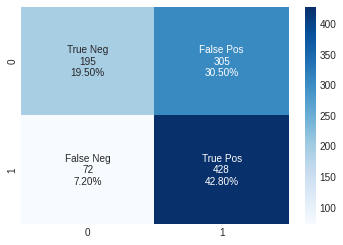

In [12]:
cm = confusion_matrix(y_true, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

### Other Results-Outcomes

plot_images() plots 25 images in a list of names. It rreceives the index to begin (n1)

In [13]:
def plot_images(images_names, n1):
  n2 = n1+25
  _, axes = plt.subplots(int(math.sqrt(n2-n1)), int(math.sqrt(n2-n1)), figsize=(20, 20))
  for match, ax in zip(images_names[n1:n2], axes.flatten()):
    image = cv2.imread(f"{CFG.image_path}/{match}") 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis("off")

  plt.show()

Get indexes where predictions are not correct

In [ ]:
y_pred = [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
y_true = test['misogynous'].values.tolist()

# Print predicted and true labels
print(y_true)
print(y_pred)
# Cpmpare lists elementwie and get True where elements are same and False when they are different
a = (np.array(y_true)==np.array(y_pred))
#false_pos = (np.array(y_true)==np.array(y_pred) and np.array(y_true).any(0))
#false_neg = (np.array(y_true)==np.array(y_pred)and np.array(y_true).any(1))
# Get indexes where a is False (bad prediction)
i = np.argwhere(a==False).T[0]
false_pos = i[np.argwhere(np.array(y_true)[i]==0).T[0]]
false_neg = i[np.argwhere(np.array(y_true)[i]==1).T[0]]
print('Number of wrong predictions: ', len(i))
print(false_pos)


Plot 25 images that were wrongly predicted from the train set. 

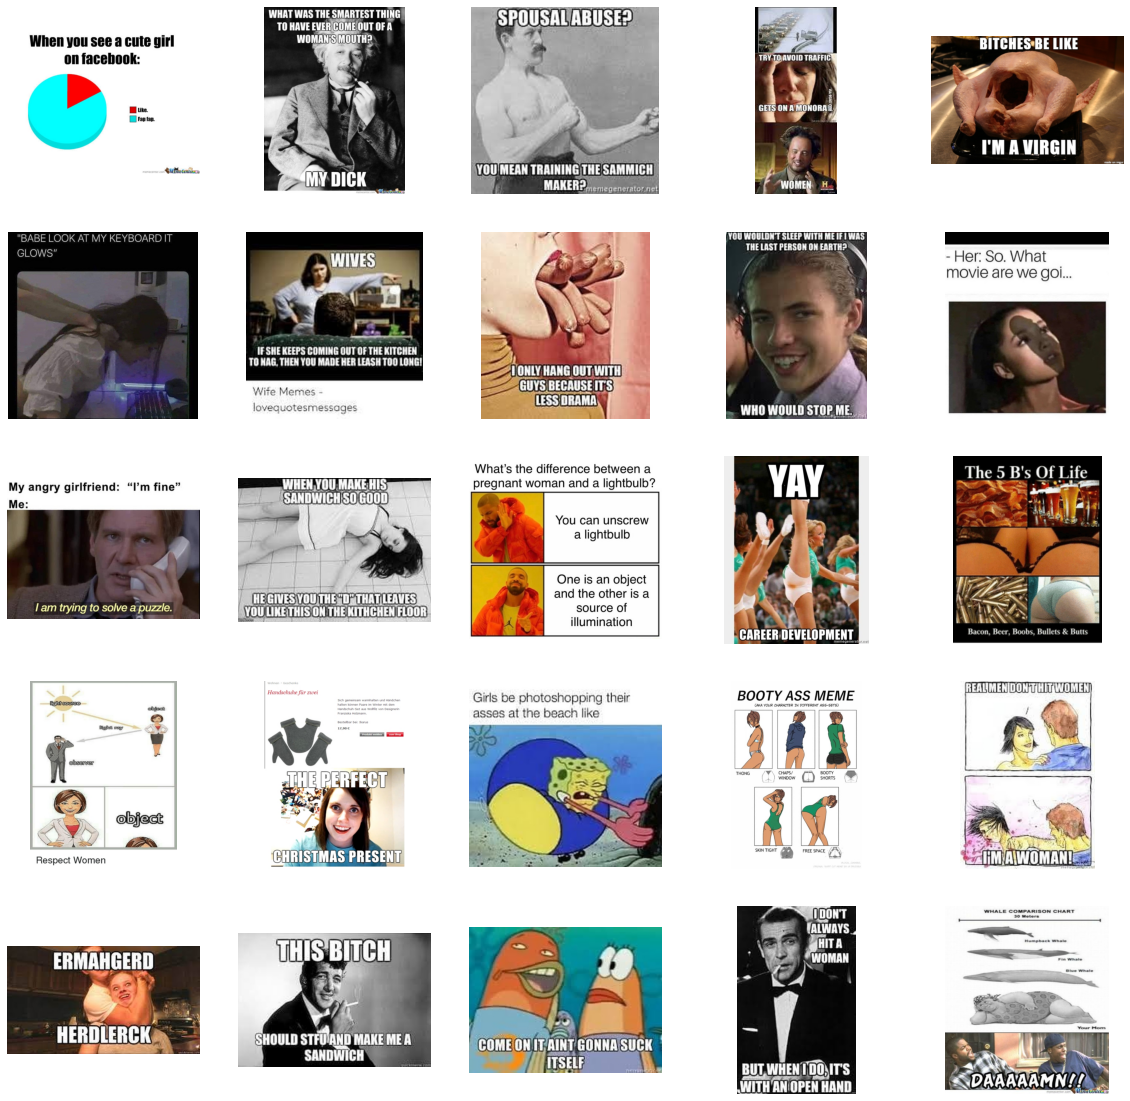

In [20]:
#train = pd.read_csv(dir_path+'train.csv', header='infer', keep_default_na=False)
false_pos_imgnames = test.iloc[false_pos, :].file_name # Get list of wrong predicted images file NAMES  (305)
false_neg_imgnames = test.iloc[false_neg, :].file_name # Get list of wrong predicted images file NAMES (75)

n1 = 25 # Multiples of 25
plot_images(false_neg_imgnames, n1)

## Tests

In [ ]:
timm.list_models()